# Realization of Non-Recursive Filters

*This jupyter notebook is part of a [collection of notebooks](../index.ipynb) on various topics of Digital Signal Processing. Please direct questions and suggestions to [Sascha.Spors@uni-rostock.de](mailto:Sascha.Spors@uni-rostock.de).*

## Fast Convolution

The straightforward convolution of two finite-length signals $x[k]$ and $h[k]$ is a numerically complex task. This has led to the development of various techniques with considerably lower complexity. The basic concept of the *fast convolution* is to exploit the correspondence between the convolution and the scalar multiplication in the frequency domain.

### Convolution of Finite-Length Signals

The convolution of a causal signal $x_L[k]$ of length $L$ with a causal impulse response $h_N[k]$ of length $N$ is given as

\begin{equation}
y[k] = x_L[k] * h_N[k] = \sum_{\kappa = 0}^{L-1} x_L[\kappa] \; h_N[k - \kappa] = \sum_{\kappa = 0}^{N-1} h_N[\kappa] \; x_L[k - \kappa]
\end{equation}

where $x_L[k] = 0$ for $k<0 \wedge k \geq L$ and $h_N[k] = 0$ for $k<0 \wedge k \geq N$. The resulting signal $y[k]$ is of finite length $M = N+L-1$. The computation of $y[k]$ for $k=0,1, \dots, M-1$ requires $M \cdot N$ multiplications and $M \cdot (N-1)$ additions. The computational complexity of the convolution is consequently [in the order of](https://en.wikipedia.org/wiki/Big_O_notation) $\mathcal{O}(M \cdot N)$. Discrete-time Fourier transformation (DTFT) of above relation yields

\begin{equation}
Y(e^{j \Omega}) = X_L(e^{j \Omega}) \cdot H_N(e^{j \Omega})
\end{equation}

Discarding the effort of transformation, the computationally complex convolution is replaced by a scalar multiplication with respect to the frequency $\Omega$. However, $\Omega$ is a continuous frequency variable which limits the numerical evaluation of this scalar multiplication. In practice, the DTFT is replaced by the discrete Fourier transformation (DFT). Two aspects have to be considered before a straightforward application of the DFT

1. The DFTs $X_L[\mu]$ and $H_N[\mu]$ are of length $L$ and $N$ respectively and cannot be multiplied straightforwardly
    
2. For $N = L$, the multiplication of the two spectra $X_L[\mu]$ and $H_L[\mu]$ would result in the [periodic/circular convolution](https://en.wikipedia.org/wiki/Circular_convolution) $x_L[k] \circledast_L h_L[k]$ due to the periodicity of the DFT. Since we aim at realizing the linear convolution $x_L[k] * h_N[k]$ with the DFT, special care has to be taken to avoid cyclic effects.

### Linear Convolution by Periodic Convolution

The periodic convolution of the two signals $x_L[k]$ and $h_N[k]$ is defined as

\begin{equation}
x_L[k] \circledast_M h_N[k] = \sum_{\kappa=0}^{M-1} \tilde{x}_M[k - \kappa] \; \tilde{h}_M[\kappa]
\end{equation}

where the periodic continuations $\tilde{x}_M[k]$ of $x_L[k]$ and $\tilde{h}_M[k]$ of $h_N[k]$ with period $M$ are given as

\begin{align}
\tilde{x}_M[k] &= \sum_{m = -\infty}^{\infty} x_L[m \cdot M + k] \\
\tilde{h}_M[k] &= \sum_{m = -\infty}^{\infty} h_N[m \cdot M + k]
\end{align}

The result of the circular convolution has a periodicity of $M$.

To compute the linear convolution by the periodic convolution one has to take care that the result of the linear convolution fits into one period of the periodic convolution. Hence, the periodicity has to be chosen as $M \geq N+L-1$. This can be achieved by zero-padding of $x_L[k]$ and $h_N[k]$ to a total length of $M$

\begin{align}
x_M[k] &= \begin{cases}
x_L[k] & \mathrm{for} \; k=0, 1, \dots, L-1 \\
0 & \mathrm{for} \; k=L, L+1, \dots, M-1
\end{cases}
\\
h_M[k] &= \begin{cases}
h_N[k] & \mathrm{for} \; k=0, 1, \dots, N-1 \\
0 & \mathrm{for} \; k=N, N+1, \dots, M-1
\end{cases}
\end{align}

This results in the desired equality of linear and periodic convolution

\begin{equation}
x_L[k] * h_N[k] = x_M[k] \circledast_M h_M[k]
\end{equation}

for $k = 0,1,\dots, M-1$ with $M = N+L-1$.

#### Example - Linear by periodic convolution

The following example computes the linear, periodic and linear by periodic convolution of a rectangular signal $x[k] = \text{rect}_L[k]$ of length $L$ with a triangular signal $h[k] = \Lambda_N[k]$ of length $N$.

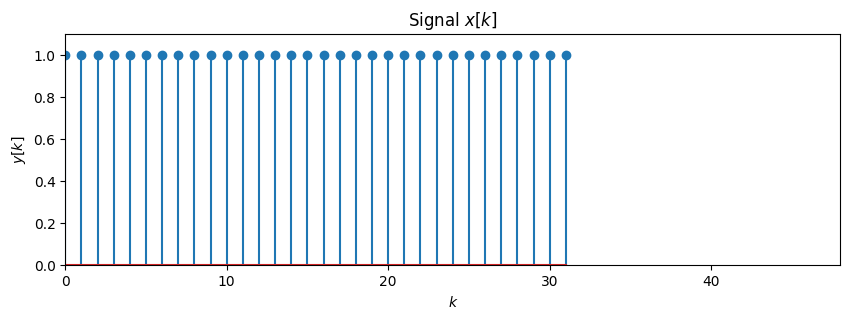

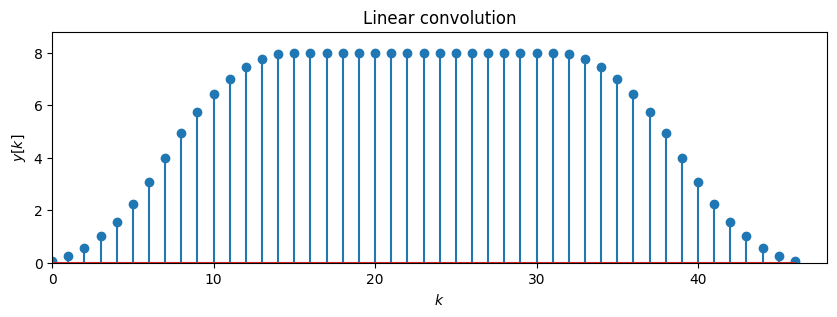

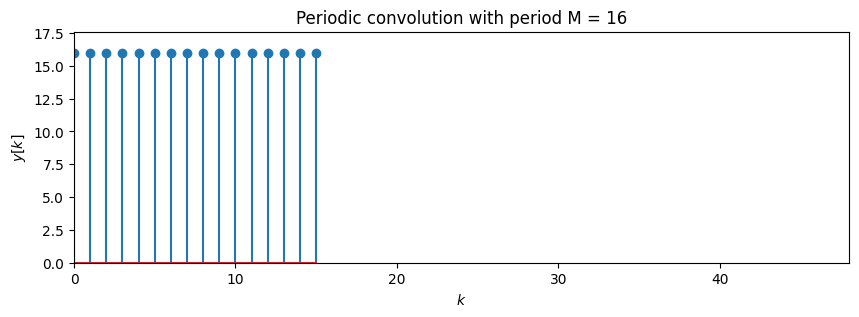

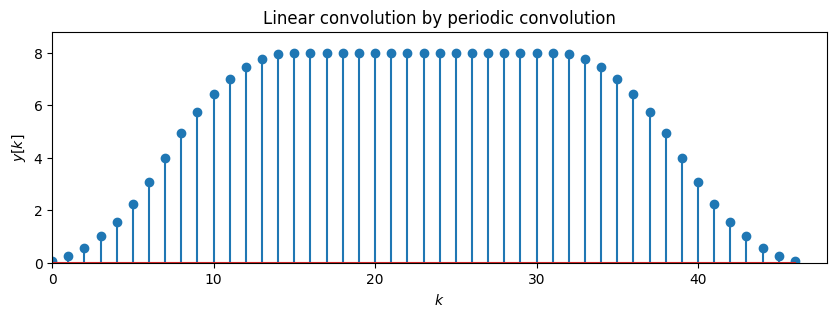

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig

L = 32  # length of signal x[k]
N = 16  # length of signal h[k]
M = 16  # periodicity of periodic convolution


def periodic_summation(x, N):
    "Zero-padding to length N or periodic summation with period N."
    M = len(x)
    rows = int(np.ceil(M / N))

    if M < int(N * rows):
        x = np.pad(x, (0, int(N * rows - M)), "constant")

    x = np.reshape(x, (rows, N))

    return np.sum(x, axis=0)


def periodic_convolve(x, y, P):
    "Periodic convolution of two signals x and y with period P."
    x = periodic_summation(x, P)
    h = periodic_summation(y, P)

    return np.array([np.dot(np.roll(x[::-1], k + 1), h) for k in range(P)], float)


# generate signals
x = np.ones(L)
h = sig.windows.triang(N)

# linear convolution
y1 = np.convolve(x, h, "full")
# periodic convolution
y2 = periodic_convolve(x, h, M)
# linear convolution via periodic convolution
xp = np.append(x, np.zeros(N - 1))
hp = np.append(h, np.zeros(L - 1))
y3 = periodic_convolve(xp, hp, L + N - 1)


def plot_signal(x):
    """Plots the signals in stem plot."""
    plt.figure(figsize=(10, 3))
    plt.stem(x)
    plt.xlabel(r"$k$")
    plt.ylabel(r"$y[k]$")
    plt.axis([0, N + L, 0, 1.1 * x.max()])


# plot results
plot_signal(x)
plt.title("Signal $x[k]$")
plot_signal(y1)
plt.title("Linear convolution")
plot_signal(y2)
plt.title("Periodic convolution with period M = %d" % M)
plot_signal(y3)
plt.title("Linear convolution by periodic convolution");

**Exercise**

* Change the lengths `L`, `N` and `M` and check how the results for the different convolutions change

### The Fast Convolution

Using the above derived equality of the linear and periodic convolution one can express the linear convolution $y[k] = x_L[k] * h_N[k]$ by the DFT as

\begin{equation}
y[k] = \text{IDFT}_M \{ \; \text{DFT}_M\{ x_M[k] \} \cdot \text{DFT}_M\{ h_M[k] \} \; \}
\end{equation}

This operation requires three DFTs of length $M$ and $M$ complex multiplications. On first sight this does not seem to be an improvement, since one DFT/IDFT requires $M^2$ complex multiplications and $M \cdot (M-1)$ complex additions. The overall numerical complexity is hence in the order of $\mathcal{O}(M^2)$. The DFT can be realized efficiently by the [fast Fourier transformation](https://en.wikipedia.org/wiki/Fast_Fourier_transform) (FFT), which lowers the computational complexity to $\mathcal{O}(M \log_2 M)$. The resulting algorithm is known as *fast convolution* due to its computational efficiency. 

The fast convolution algorithm is composed of the following steps

1. Zero-padding of the two input signals $x_L[k]$ and $h_N[k]$ to at least a total length of $M \geq N+L-1$

2. Computation of the DFTs $X[\mu]$ and $H[\mu]$ using a FFT of length $M$

3. Multiplication of the spectra $Y[\mu] = X[\mu] \cdot H[\mu]$

4. Inverse DFT of $Y[\mu]$ using an inverse FFT of length $M$

The overall complexity depends on the particular implementation of the FFT. Many FFTs are most efficient for lengths which are a power of two. It therefore can make sense, in terms of computational complexity, to choose $M$ as a power of two instead of the shortest possible length $N+L-1$. For real valued signals $x[k] \in \mathbb{R}$ and $h[k] \in \mathbb{R}$ the computational complexity can be reduced significantly by using a real valued FFT.

#### Example - Fast convolution

The implementation of the fast convolution algorithm is straightforward. Most implementations of the FFT include zero-padding to a given length $M$, e.g in `numpy` by `numpy.fft.fft(x, M)`. In the following example an implementation of the fast convolution is shown. For illustration the convolution of a rectangular signal $x[k] = \text{rect}_L[k]$ of length $L$ with a triangular signal $h[k] = \Lambda_N[k]$ of length $N$ is considered.

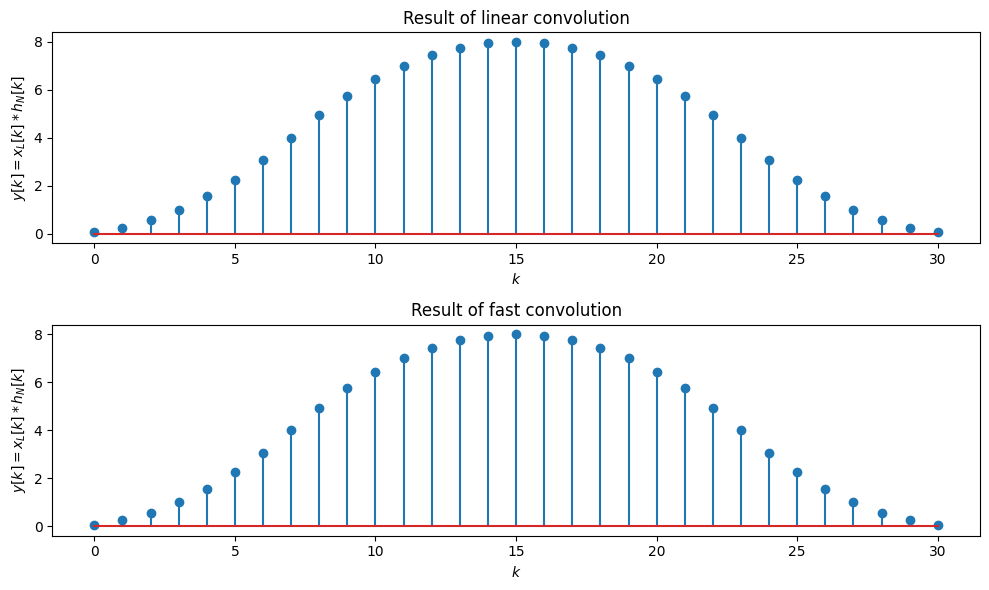

In [2]:
L = 16  # length of signal x[k]
N = 16  # length of signal h[k]
M = N + L - 1

# generate signals
x = np.ones(L)
h = sig.windows.triang(N)

# linear convolution
y1 = np.convolve(x, h, "full")
# fast convolution
y2 = np.fft.ifft(np.fft.fft(x, M) * np.fft.fft(h, M))

plt.figure(figsize=(10, 6))
plt.subplot(211)
plt.stem(y1)
plt.xlabel(r"$k$")
plt.ylabel(r"$y[k] = x_L[k] * h_N[k]$")
plt.title("Result of linear convolution")

plt.subplot(212)
plt.stem(y1)
plt.xlabel(r"$k$")
plt.ylabel(r"$y[k] = x_L[k] * h_N[k]$")
plt.title("Result of fast convolution")
plt.tight_layout()

#### Example - Numerical complexity

It was already argued that the numerical complexity of the fast convolution is considerably lower due to the usage of the FFT. The gain with respect to the convolution is evaluated in the following. In order to measure the execution times for both algorithms the `timeit` module is used. The algorithms are evaluated for the convolution of two random signals $x_L[k]$ and $h_N[k]$ of length $L=N=2^n$ for $n=0, 1, \dots, 16$.

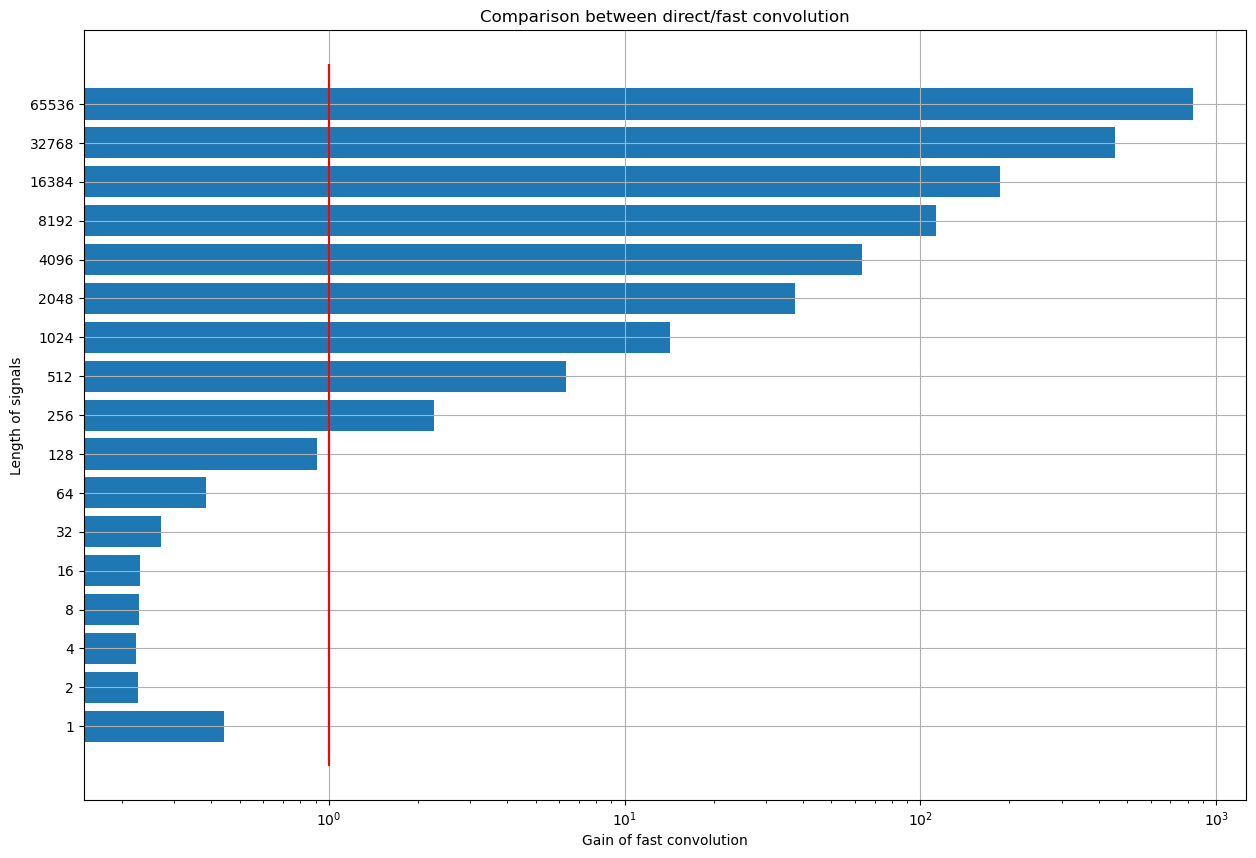

In [3]:
import timeit

n = np.arange(17)  # lengths = 2**n to evaluate
reps = 50  # number of repetitions for timeit

gain = np.zeros(len(n))
for N in n:
    length = 2**N
    # setup environment for timeit
    tsetup = (
        "import numpy as np; from numpy.fft import rfft, irfft; \
            x=np.random.randn(%d); h=np.random.randn(%d)"
        % (length, length)
    )
    # direct convolution
    tc = timeit.timeit('np.convolve(x, x, mode="full")', setup=tsetup, number=reps)
    # fast convolution
    tf = timeit.timeit(
        "irfft(rfft(x, %d) * rfft(h, %d))" % (2 * length, 2 * length),
        setup=tsetup,
        number=reps,
    )
    # speedup by using the fast convolution
    gain[N] = tc / tf

# show the results
plt.figure(figsize=(15, 10))
plt.barh(n, gain, log=True)
plt.plot([1, 1], [-1, n[-1] + 1], "r-")
plt.yticks(n, 2**n)
plt.xlabel("Gain of fast convolution")
plt.ylabel("Length of signals")
plt.title("Comparison between direct/fast convolution")
plt.grid()

**Exercise**

* When is the fast convolution more efficient/faster than a direct convolution? 
* Why is it slower below a given signal length?
* Is the trend of the gain as expected by the numerical complexity of the FFT?

Solution: The gain in execution time of a fast convolution over a direct implementation of the the convolution for different signal lengths depends heavily on the particular implementation and hardware used. The fast convolution in this example is faster for two signals having a length equal or larger than 1024 samples. Discarding the outliers and short lengths, the overall trend in the gain is approximately logarithmic as predicted above.

**Copyright**

This notebook is provided as [Open Educational Resource](https://en.wikipedia.org/wiki/Open_educational_resources). Feel free to use the notebook for your own purposes. The text is licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/), the code of the IPython examples under the [MIT license](https://opensource.org/licenses/MIT). Please attribute the work as follows: *Sascha Spors, Digital Signal Processing - Lecture notes featuring computational examples*.